# PIP Assignment #1
##F1 Pitstop Strategy App

### Problem Statement

I want to help Formula 1 race engineers and strategists to make smarter pit stop decisions by combining historical race data with real-time weather insights and precise track locations.  

- **Goal:** Predict the optimal number of pit stops for a race based on track history, current conditions, and track coordinates, helping teams gain a strategic edge.  
- **Data Sources:**  
  - **FastF1:** Historical race data including laps, pit stops, stint lengths, and past race weather.  
  - **Open-Meteo:** Live weather information to adapt strategy to current track conditions.  
  - **Nominatim (OpenStreetMap):** Converts track names into latitude and longitude to fetch accurate weather data.  



## APIs Used

| API | Purpose | How Used |
|-----|---------|----------|
| FastF1 | Historical race & lap data | Provides pit stop counts, stint lengths, and past race weather |
| Open-Meteo | Current weather forecast | Provides temperature at race location for strategy comparison |
| Nominatim | Geocoding (track name → coordinates) | Converts track name into latitude and longitude |


## Data Flowchart

```text
[User inputs track name & year]
          |
          v
[Nominatim API] -> Get lat/lon of track
          |
          v
[Open-Meteo API] -> Get current temperature & simple weather label
          |
          v
[FastF1 Library] -> Load last 3 years of race data for the track
          |
          v
[Combine Data] -> Compare historical pit stops for similar weather
          |
          v
[Output Recommendation] -> Avg pit stops + plots + per-driver distribution


## How the Code Works

1. **Setup**
   - Install required libraries (`fastf1`, `requests`, `pandas`, `matplotlib`, `seaborn`)  
   - Create FastF1 cache folder for faster session loading  

2. **Helper Functions**
   - `get_lat_lon(track_name)` → Uses Nominatim API to get latitude & longitude  
   - `get_current_weather(lat, lon)` → Uses Open-Meteo API to get current temperature and classify weather as 'hot' or 'cool'  

3. **Main Function: `analyze_strategy(event, year)`**
   - Loads the last 3 years of race data for the given track using FastF1  
   - Counts pit stops per driver and calculates average stops & stint length  
   - Classifies past race weather as 'hot' or 'cool'  
   - Plots historical average pit stops and per-driver distribution  
   - Fetches current weather using Open-Meteo  
   - Recommends pit stops based on weather-matched historical data  

4. **Testing Loop**
   - Runs the analysis for at least 3 different tracks to validate the program



## How to Run This Notebook

This notebook analyzes F1 pit stop strategies using historical race data and current weather. It uses three APIs:

- **FastF1**: Provides historical F1 race data (no API key required)  
- **Open-Meteo**: Provides current weather data (no API key required)  
- **Nominatim (OpenStreetMap)**: Converts track names to coordinates (no API key required, only a User-Agent header)

### Steps to Run
1. Open the notebook in Google Colab.  
2. Run the first code cell to install required libraries (`fastf1`, `requests`, `pandas`, `matplotlib`, `seaborn`).  
3. Run all code cells in order:
   - Setup FastF1 cache
   - Helper functions
   - Main analysis function
   - Testing loop for example tracks  
4. The notebook is fully functional and requires **no API keys**.  


**INSTALL & IMPORT LIBRARIES**


In [8]:
!pip install fastf1 --upgrade  # Install FastF1 library (for historical F1 data)
!pip install requests          # Install Requests library (for calling web APIs)
!pip install pandas matplotlib seaborn  # install Pandas, Matplotlib, and Seaborn for data analysis & visualization


import os             # Import OS library for file/folder operations
import fastf1         #import FastF1 library
import pandas as pd   # import Pandas for dataframes
import requests       # Import Requests for API calls
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
import seaborn as sns #Import Seaborn for enhanced plotting


**SETUP FASTF1 CACHE**  
This block ensures *f1_cache* folder exits and activates caching in that folder.


In [9]:
# Check if cache folder exists, if not, create it
if not os.path.exists('f1_cache'):
    os.makedirs('f1_cache')  # Create folder for caching FastF1 sessions

# Enable FastF1 caching to speed up repeated data loads
fastf1.Cache.enable_cache('f1_cache')


**Helper Functions: For track Coordinates and Current Weather**

In [10]:
# HELPER FUNCTION: GET TRACK COORDINATES
def get_lat_lon(track_name):
    """
    Input: track name (string)
    Output: latitude and longitude of track (floats)
    Uses Nominatim API to convert track name to coordinates
    """
    # API endpoint for Nominatim geocoding
    url = "https://nominatim.openstreetmap.org/search"

    # header required by Nominatim API (must include User-Agent)
    headers = {"User-Agent": "F1-Pitstop-Strategy-App/1.0 "}

    #parameters for the request: query (track_name) and want a JSON response (easy for python to parse)
    params = {"q": track_name, "format": "json"}

    try:
        # send GET request to Nominatim API
        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status()  # Raise error if request failed

        #Parse JSON response into a python object (list of dictionaries)
        data = response.json()

        if data:  # if results found
            # Return latitude and longitude as floats
            return float(data[0]['lat']), float(data[0]['lon'])
        else:
            # No results found for the track
            print(" No results found for", track_name)
            return None, None
    except Exception as e:
        # catch any request errors
        print(" Error fetching coordinates:", e)
        return None, None

In [11]:
#  GET CURRENT WEATHER
def get_current_weather(lat, lon):
    """
    Input: latitude and longitude
    Output: simplified weather ('hot' or 'cool') and temperature in Celsius
    Uses Open-Meteo API for current weather
    """
    # Construct API URL with latitude and longitude
    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current_weather=true&timezone=UTC"

    try:
        # Send GET request to Open-Meteo API
        response = requests.get(url)

        # Convert response from JSON to python dictionary
        data = response.json()

        # Extract current temperature
        temp = data['current_weather']['temperature']

        # Simplify weather into categories
        if temp >= 25:
            return "hot", temp
        else:
            return "cool", temp
    except Exception as e:
        # Catch any request errors
        print(" Failed to retrieve weather:", e)
        return None, None

**MAIN FUNCTION: Analyze Strategy**

In [12]:
# MAIN FUNCTION: ANALYZE STRATEGY
def analyze_strategy(event, year):
    """
    Input: track name (event) and year
    Output: historical pit stop data, plots, and recommendation based on current weather
    Combines FastF1 historical data and Open-Meteo current weather
    """
    #Step 1: Get track coordinates using helper function from the above
    lat, lon = get_lat_lon(event)

    if lat is None or lon is None:  # If coordinates not found
        print("Cannot proceed without coordinates.")
        return

    # List to store historical data for past 3 years
    historical = []

    # Step 2: Loop through the past 3 years
    for past_year in range(year-3, year):
        try:
            # Load race session from FastF1
            session = fastf1.get_session(past_year, event, 'R')  # 'R' = Race session
            session.load()  # Download session if not cached

            # Get all laps for all drivers into a pandas DataFrame
            df_laps = session.laps

            # Identify pit stops (1 if PitOutTime exists, else 0)
            df_laps['PitStopFlag'] = df_laps['PitOutTime'].notna().astype(int)

            # Count pit stops per driver
            df_summary = df_laps.groupby('Driver')['PitStopFlag'].sum().reset_index()

            # Get maximum lap number per driver (for position reference)
            df_summary = df_summary.merge(
                df_laps.groupby('Driver')['LapNumber'].max().reset_index(),
                on='Driver'
            ).rename(columns={'LapNumber':'Position'})

            # Store pit stops as integer
            df_summary['PitStops'] = df_summary['PitStopFlag'].astype(int)

            # Remove helper column
            df_summary.drop(columns=['PitStopFlag'], inplace=True)

            # Calculate average pit stops
            avg_stops = df_summary['PitStops'].mean()

            # Calculate average stint length
            avg_stint = df_laps['LapNumber'].max() / max(avg_stops, 1)

            # Determine race weather using FastF1 session data
            weather_data = session.weather_data
            avg_temp = weather_data['AirTemp'].mean()
            weather = "hot" if avg_temp >= 25 else "cool"

            # Store historical data for plotting & recommendation
            historical.append({
                "year": past_year,
                "avg_stops": round(avg_stops, 2),
                "avg_stint": round(avg_stint, 1),
                "weather": weather,
                "df_summary": df_summary
            })

        except Exception as e:
            # Handle missing sessions or errors
            print(f" Could not load {past_year}: {e}")

    # Convert historical list to DataFrame
    hist_df = pd.DataFrame(historical)

    # Display summary of historical pit stops
    print("\n Historical data (last 3 years):")
    print(hist_df[['year','avg_stops','avg_stint','weather']])

    #Step 3: Plot historical average pit stops per year
    plt.figure(figsize=(8,4))
    sns.barplot(x="year", y="avg_stops", hue="weather", data=hist_df, palette={"hot":"red","cool":"blue"})
    plt.title(f"{event} - Average Pit Stops (last 3 years)")
    plt.ylabel("Avg Pit Stops")
    plt.xlabel("Year")
    plt.legend(title="Weather")
    plt.show()

    # Step 4: Plot pit stop distribution per driver for each year
    for record in historical:
        df_summary = record['df_summary']
        print(f"\n--- {record['year']} ({record['weather']}) ---")
        print(df_summary.sort_values('PitStops'))

        plt.figure(figsize=(6,3))
        bins = range(df_summary['PitStops'].min(), df_summary['PitStops'].max() + 2)  # Integer bins
        sns.histplot(df_summary['PitStops'], bins=bins, color='skyblue', discrete=True)
        plt.title(f"{record['year']} Pit Stops Distribution")
        plt.xlabel("Number of Pit Stops")
        plt.ylabel("Number of Drivers")
        plt.show()

    #step 5: Get current weather for recommendation
    current_weather, temp = get_current_weather(lat, lon)
    print(f"\n Current Weather near track: {temp}°C → {current_weather}")

    # step 6: Recommend pit stops based on current weather
    if current_weather:
        # Filter historical data for matching weather
        filtered = hist_df[hist_df['weather'] == current_weather]
        if not filtered.empty:
            # Average pit stops for that weather
            rec = filtered['avg_stops'].mean()
            print(f"\n👉 Recommended pit stops for {current_weather} conditions ≈ {rec:.1f}")
        else:
            # Fallback if no matching weather data
            print("\n⚠️ No historical data for this weather type. Fallback to overall average.")
            print(f"Recommended stops ≈ {hist_df['avg_stops'].mean():.1f}")
    else:
        # If weather unknown
        print("\n⚠️ Weather unknown → Only historical baseline strategies available.")


**TESTING LOOP**



=== Yas Marina Circuit, Abu Dhabi ===


events      WARNING 	Correcting user input 'Yas Marina Circuit, Abu Dhabi' to 'Abu Dhabi Grand Prix'
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using c


 Historical data (last 3 years):
   year  avg_stops  avg_stint weather
0  2022       1.55       37.4     hot
1  2023       1.85       31.4     hot
2  2024       1.40       41.4     hot


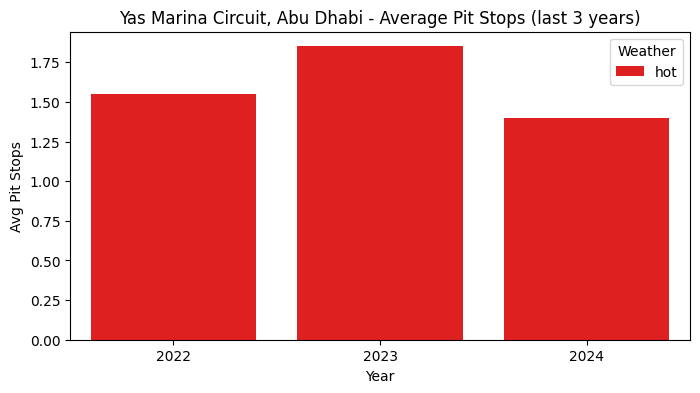


--- 2022 (hot) ---
   Driver  Position  PitStops
1     ALO      27.0         1
2     BOT      57.0         1
3     GAS      57.0         1
4     HAM      55.0         1
7     MAG      57.0         1
6     LEC      58.0         1
12    RIC      58.0         1
17    VER      58.0         1
18    VET      58.0         1
8     MSC      57.0         2
5     LAT      55.0         2
9     NOR      58.0         2
11    PER      58.0         2
13    RUS      58.0         2
10    OCO      58.0         2
0     ALB      57.0         2
15    STR      58.0         2
14    SAI      58.0         2
16    TSU      58.0         2
19    ZHO      57.0         2


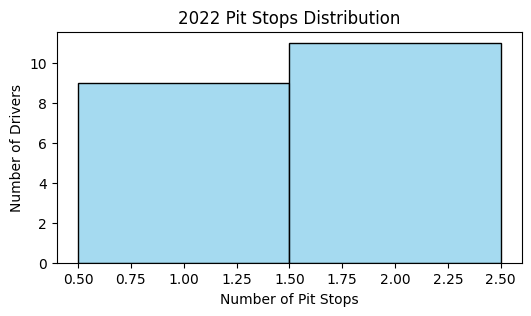


--- 2023 (hot) ---
   Driver  Position  PitStops
2     BOT      57.0         1
9     OCO      58.0         1
17    TSU      58.0         1
1     ALO      58.0         2
4     HAM      58.0         2
5     HUL      58.0         2
6     LEC      58.0         2
0     ALB      58.0         2
7     MAG      57.0         2
8     NOR      58.0         2
10    PER      58.0         2
11    PIA      58.0         2
12    RIC      58.0         2
13    RUS      58.0         2
14    SAI      57.0         2
3     GAS      58.0         2
15    SAR      58.0         2
16    STR      58.0         2
18    VER      58.0         2
19    ZHO      58.0         2


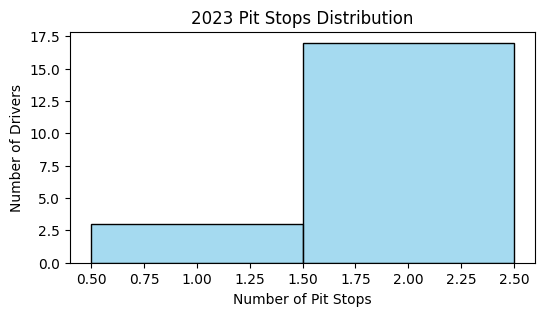


--- 2024 (hot) ---
   Driver  Position  PitStops
12    PER       1.0         0
0     ALB      57.0         1
3     COL      26.0         1
2     BOT      30.0         1
6     HAM      58.0         1
5     GAS      58.0         1
7     HUL      58.0         1
4     DOO      57.0         1
15    SAI      58.0         1
9     LEC      58.0         1
14    RUS      58.0         1
11    NOR      58.0         1
18    VER      58.0         1
17    TSU      57.0         1
1     ALO      58.0         2
13    PIA      58.0         2
16    STR      57.0         2
19    ZHO      57.0         2
8     LAW      56.0         3
10    MAG      57.0         4


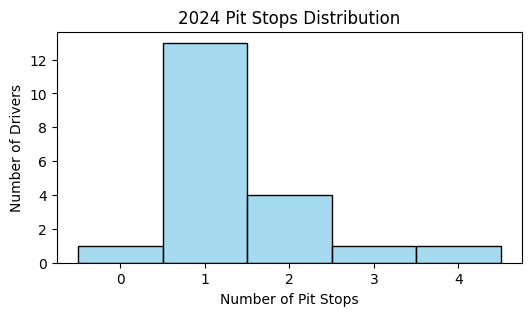


 Current Weather near track: 33.2°C → hot

👉 Recommended pit stops for hot conditions ≈ 1.6


=== Monaco Grand Prix ===


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           


 Historical data (last 3 years):
   year  avg_stops  avg_stint weather
0  2022       3.65       17.5    cool
1  2023       1.85       42.2     hot
2  2024       1.15       67.8    cool


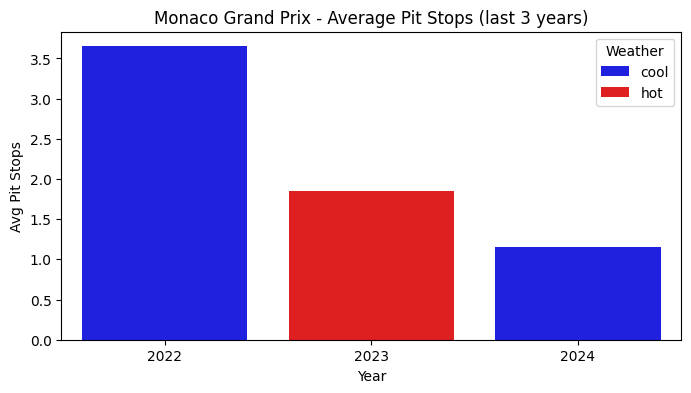


--- 2022 (cool) ---
   Driver  Position  PitStops
7     MAG      20.0         1
1     ALO      64.0         3
2     BOT      64.0         3
14    SAI      64.0         3
12    RIC      64.0         3
13    RUS      64.0         3
10    OCO      64.0         3
8     MSC      25.0         3
19    ZHO      63.0         3
0     ALB      49.0         4
4     HAM      64.0         4
6     LEC      64.0         4
11    PER      64.0         4
18    VET      64.0         4
17    VER      64.0         4
3     GAS      64.0         4
15    STR      64.0         5
9     NOR      64.0         5
5     LAT      63.0         5
16    TSU      63.0         5


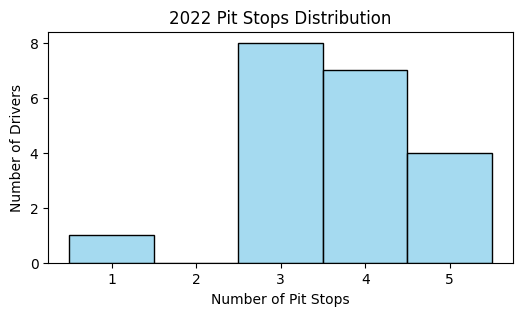


--- 2023 (hot) ---
   Driver  Position  PitStops
3     DEV      77.0         1
2     BOT      77.0         1
12    PIA      77.0         1
8     MAG      71.0         1
13    RUS      78.0         1
18    VER      78.0         1
17    TSU      76.0         1
16    STR      54.0         1
14    SAI      78.0         2
7     LEC      78.0         2
5     HAM      78.0         2
9     NOR      77.0         2
10    OCO      78.0         2
4     GAS      78.0         2
1     ALO      78.0         2
0     ALB      77.0         2
19    ZHO      77.0         2
6     HUL      76.0         3
15    SAR      76.0         3
11    PER      76.0         5


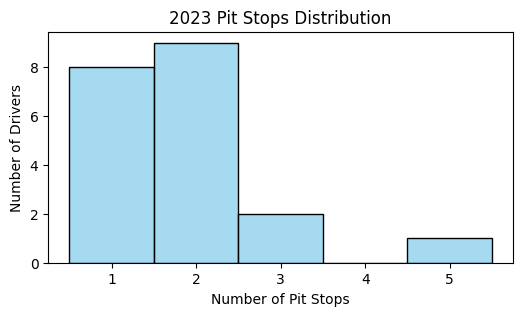


--- 2024 (cool) ---
   Driver  Position  PitStops
7     MAG       1.0         0
5     HUL       1.0         0
10    PER       1.0         0
9     OCO       1.0         0
6     LEC      78.0         1
3     GAS      77.0         1
0     ALB      77.0         1
1     ALO      76.0         1
12    RIC      76.0         1
13    RUS      78.0         1
8     NOR      78.0         1
11    PIA      78.0         1
14    SAI      78.0         1
17    TSU      77.0         1
4     HAM      78.0         2
2     BOT      76.0         2
15    SAR      76.0         2
18    VER      78.0         2
19    ZHO      76.0         2
16    STR      76.0         3


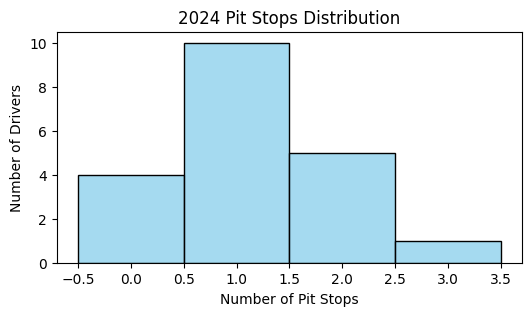


 Current Weather near track: 27.6°C → hot

👉 Recommended pit stops for hot conditions ≈ 1.9


=== Silverstone Circuit, UK ===


events      WARNING 	Correcting user input 'Silverstone Circuit, UK' to 'British Grand Prix'
core           INFO 	Loading data for British Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data f


 Historical data (last 3 years):
   year  avg_stops  avg_stint weather
0  2022       2.35       22.1    cool
1  2023       1.20       43.3    cool
2  2024       2.30       22.6    cool


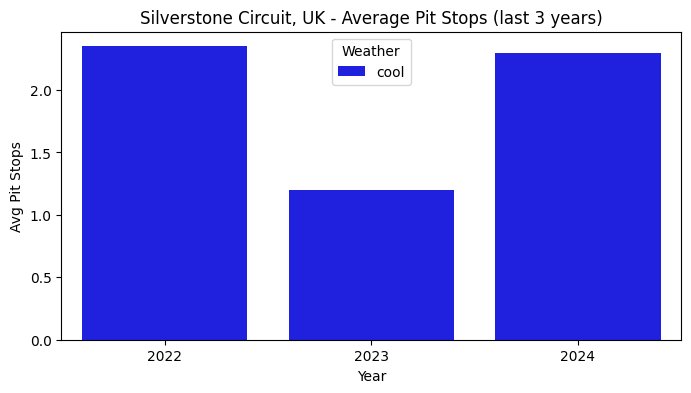


--- 2022 (cool) ---
   Driver  Position  PitStops
0     ALB       1.0         0
13    RUS       1.0         0
19    ZHO       1.0         0
2     BOT      20.0         1
6     LEC      52.0         2
7     MAG      52.0         2
10    OCO      38.0         2
3     GAS      26.0         2
4     HAM      52.0         3
5     LAT      52.0         3
9     NOR      52.0         3
8     MSC      52.0         3
11    PER      52.0         3
14    SAI      52.0         3
15    STR      52.0         3
1     ALO      52.0         3
18    VET      52.0         3
16    TSU      52.0         3
12    RIC      52.0         4
17    VER      52.0         4


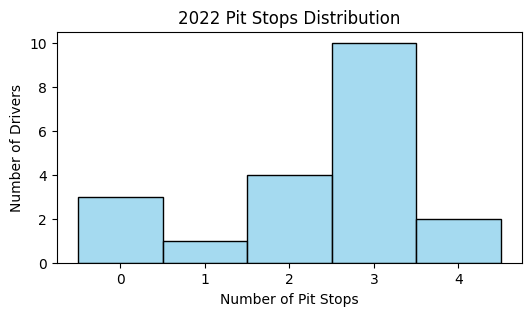


--- 2023 (cool) ---
   Driver  Position  PitStops
10    OCO       9.0         0
8     MAG      32.0         0
0     ALB      52.0         1
1     ALO      52.0         1
5     HAM      52.0         1
9     NOR      52.0         1
2     BOT      52.0         1
4     GAS      46.0         1
12    PIA      52.0         1
13    RUS      52.0         1
14    SAI      52.0         1
11    PER      52.0         1
15    SAR      52.0         1
16    STR      52.0         1
18    VER      52.0         1
7     LEC      52.0         2
6     HUL      52.0         2
3     DEV      52.0         2
17    TSU      52.0         2
19    ZHO      52.0         3


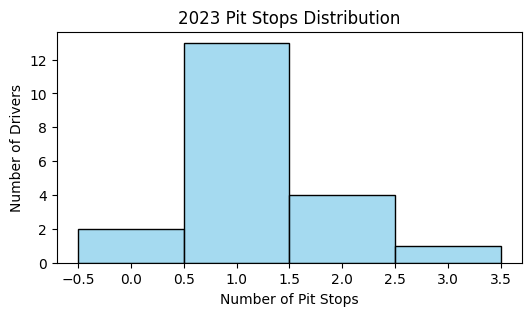


--- 2024 (cool) ---
   Driver  Position  PitStops
3     GAS       1.0         0
13    RUS      33.0         1
1     ALO      52.0         2
0     ALB      52.0         2
4     HAM      52.0         2
5     HUL      52.0         2
7     MAG      52.0         2
2     BOT      51.0         2
15    SAR      52.0         2
8     NOR      52.0         2
12    RIC      51.0         2
11    PIA      52.0         2
17    TSU      52.0         2
18    VER      52.0         2
16    STR      52.0         2
6     LEC      51.0         3
14    SAI      52.0         3
9     OCO      50.0         4
19    ZHO      50.0         4
10    PER      50.0         5


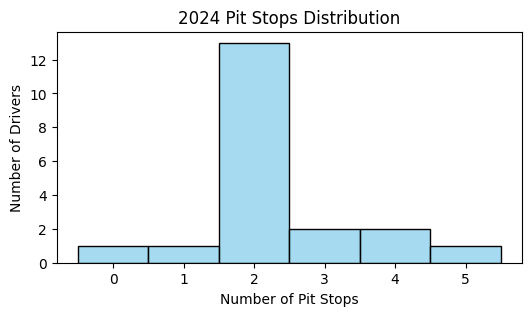


 Current Weather near track: 14.9°C → cool

👉 Recommended pit stops for cool conditions ≈ 1.9


In [13]:
# List of tracks to test
tracks = [
    "Yas Marina Circuit, Abu Dhabi",
    "Monaco Grand Prix",
    "Silverstone Circuit, UK"
]

# loop through each track and run the analysis
for track in tracks:
    print(f"\n\n=== {track} ===")
    analyze_strategy(track, 2025)  #analyzes pit stop strategy for 2025


##Screenshot of the Output

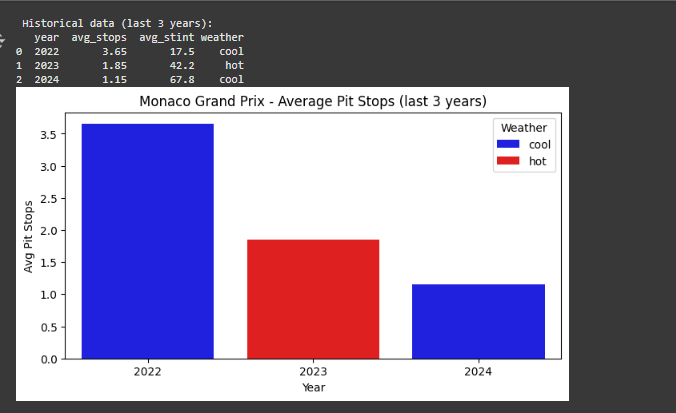

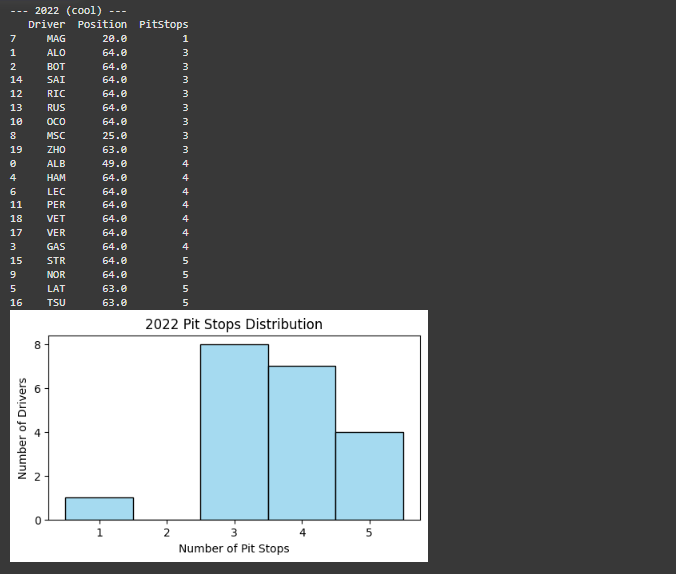

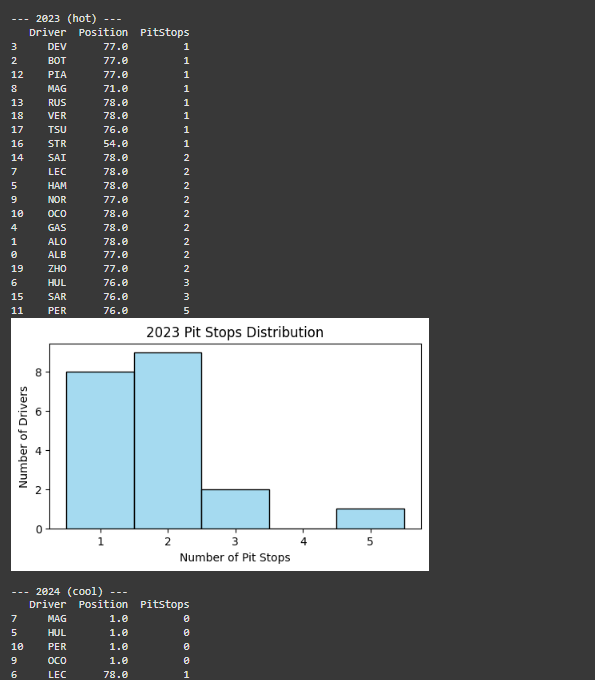

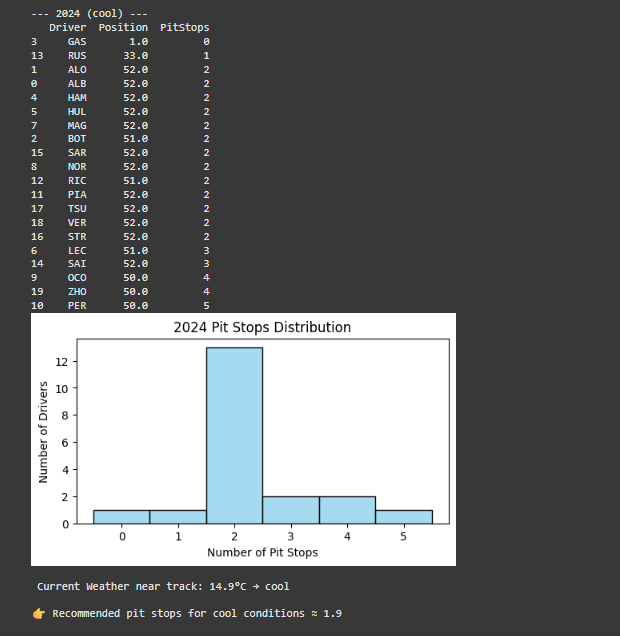

## Challenges Faced
- **Too Much API Data**  
Both FastF1 and Open-Meteo exposed a huge number of parameters, functions, and raw data points. At first, it was overwhelming to figure out which parts were actually relevant. I solved this by focusing only on the key outputs I needed: pit stop counts, lap data, and live temperature.

- **Getting Live Weather from Event Name**  
The hardest challenge was turning a string event name (e.g., "Monza") into useful weather data. This required chaining two steps:  
    - Using the Nominatim API to convert the event name into latitude and longitude.  
    -

```

Passing those coordinates to the Open-Meteo API to fetch real-time weather.

- **Simplifying Weather for Strategy**  
Raw temperature values were not directly useful. To make strategy recommendations easier, I categorized weather into just two buckets: ‘hot’ (≥25°C) or ‘cool’ (<25°C).

## Example Outputs (In the output of Testing Loop cell)

- Historical average pit stops per year (bar plots)  
- Pit stop distribution per driver (histograms)  
- Current weather near track  
- Recommended pit stops based on weather comparison  


## Reflection

The hardest part of this assignment was connecting real-time weather data to a race event. Specifically, the challenge was turning a simple string like an event name into real coordinates (latitude and longitude) and then using those to fetch the live weather. That step required chaining together two different APIs in the right order, which was tricky at first.

Another challenge was that APIs like FastF1 and Open-Meteo provide a huge amount of information, parameters, and functions—far more than I needed. I had to learn how to filter and simplify this raw data into something useful, such as categorizing temperature as “hot” or “cool.”

AI tools were especially helpful in this process. They guided me toward the relevant functions, API endpoints, and request formats while skipping the overwhelming parts of the documentation.

Overall, this project taught me how to integrate multiple APIs effectively, focus only on the pieces of data I needed, and design a workflow that turns raw information into a meaningful race strategy recommendation.